# EchoMind: Understanding Emotional Echoes in Reddit Communities

This notebook demonstrates the full workflow:
- Scraping Reddit data
- Preprocessing text
- Baseline emotion classification
- Iterative model improvements
- Visualization and insights

## Step 0: Install Required Libraries
We install all required packages for scraping, NLP, ML, and visualization.

In [ ]:
!pip install praw transformers torch tqdm plotly wordcloud scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 14.4 MB/s eta 0:00:00


## Step 1: Reddit Scraping
We use PRAW (Reddit API) to fetch posts from subreddits: Anxiety, Depression, MentalHealth.
- Limit: 1000 posts per subreddit
- Filter: Posts after Jan 1, 2024
- Save to CSV for reproducibility

In [ ]:
import praw
import pandas as pd
import datetime as dt
from google.colab import userdata # Import userdata

# Use your Colab environment variables or insert manually
reddit = praw.Reddit(client_id=userdata.get('REDDIT_CLIENT_ID'), # Get client ID from secrets
                     client_secret=userdata.get('REDDIT_CLIENT_SECRET'), # Get client secret from secrets
                     user_agent='EchoMind_Scraper')

subreddits = ['Anxiety', 'Depression', 'MentalHealth']
after = int(dt.datetime(2024, 1, 1).timestamp())

def fetch_subreddit(subreddit_name):
    posts = []
    for post in reddit.subreddit(subreddit_name).top(time_filter='year', limit=1000):
        if post.created_utc >= after:
            posts.append({
                'subreddit': subreddit_name,
                'title': post.title,
                'text': post.selftext,
                'created_utc': dt.datetime.fromtimestamp(post.created_utc)
            })
    return pd.DataFrame(posts)

df_all = pd.concat([fetch_subreddit(s) for s in subreddits])
df_all['text'] = df_all['title'] + " " + df_all['text']
df_all.to_csv("reddit_posts.csv", index=False)
df_all.head()

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

,subreddit,title,text,created_utc
0,Anxiety,"I Had a Panic Attack at Work, and My Boss Surp...","I Had a Panic Attack at Work, and My Boss Surp...",2024-10-29 00:45:02
1,Anxiety,Anyone not having kids because of crippling an...,Anyone not having kids because of crippling an...,2024-10-09 02:12:45
2,Anxiety,I sleep with a teddy bear at 27,I sleep with a teddy bear at 27 I'm so anxiou...,2024-06-12 23:09:54
3,Anxiety,So fuxking election anxiety. There is so much ...,So fuxking election anxiety. There is so much ...,2024-11-06 00:36:02
4,Anxiety,"What screams ""I'm not feeling good mentally at...","What screams ""I'm not feeling good mentally at...",2024-09-24 23:01:31


## Step 2: Text Preprocessing
Clean the text data:
- Remove links and punctuation
- Convert to lowercase
- Tokenize and lemmatize
- Remove stopwords

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df_all['cleaned'] = df_all['text'].astype(str).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Step 3: Baseline Model
We create a **simple TF-IDF(Term Frequency - Inverse Document Frequency) + Random Forest classifier** as a baseline.
- This provides a reference point for later improvements.
- We define metrics: Accuracy, Precision, Recall, F1.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_all['cleaned'], df_all['subreddit'], test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train baseline Random Forest
baseline_clf = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_clf.fit(X_train_vec, y_train)

# Predict & evaluate
y_pred_baseline = baseline_clf.predict(X_test_vec)

def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred_baseline)

Accuracy: 0.7495652173913043
Precision (macro): 0.7481573746817163
Recall (macro): 0.749346314936917
F1 Score (macro): 0.7481113343437548

Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.84      0.84      0.84       196
  Depression       0.71      0.77      0.74       186
MentalHealth       0.69      0.64      0.67       193

    accuracy                           0.75       575
   macro avg       0.75      0.75      0.75       575
weighted avg       0.75      0.75      0.75       575



## Step 4: Model Improvements
We iteratively improve the model:
1. Hyperparameter tuning (Random Forest)
2. Use Transformer embeddings (BERT/DistilBERT) for better features
3. Compare metrics at each step

In [ ]:
# Example: Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro')
grid_clf.fit(X_train_vec, y_train)

y_pred_tuned = grid_clf.predict(X_test_vec)
evaluate_model(y_test, y_pred_tuned)

Accuracy: 0.7547826086956522
Precision (macro): 0.7534757105788366
Recall (macro): 0.7547226590229384
F1 Score (macro): 0.7533052039181242

Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.84      0.84      0.84       196
  Depression       0.72      0.78      0.75       186
MentalHealth       0.70      0.64      0.67       193

    accuracy                           0.75       575
   macro avg       0.75      0.75      0.75       575
weighted avg       0.75      0.75      0.75       575



## Step 5: Transformer-Based Embeddings
- Convert text to embeddings using DistilBERT
- Train a classifier (Random Forest / Logistic Regression) on these embeddings
- Evaluate metrics

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

X_embeddings = np.array([get_embedding(txt) for txt in df_all['cleaned']])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Step 6: Visualization


/tmp/ipython-input-2715759180.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')
/tmp/ipython-input-2715759180.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')
/tmp/ipython-input-2715759180.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')


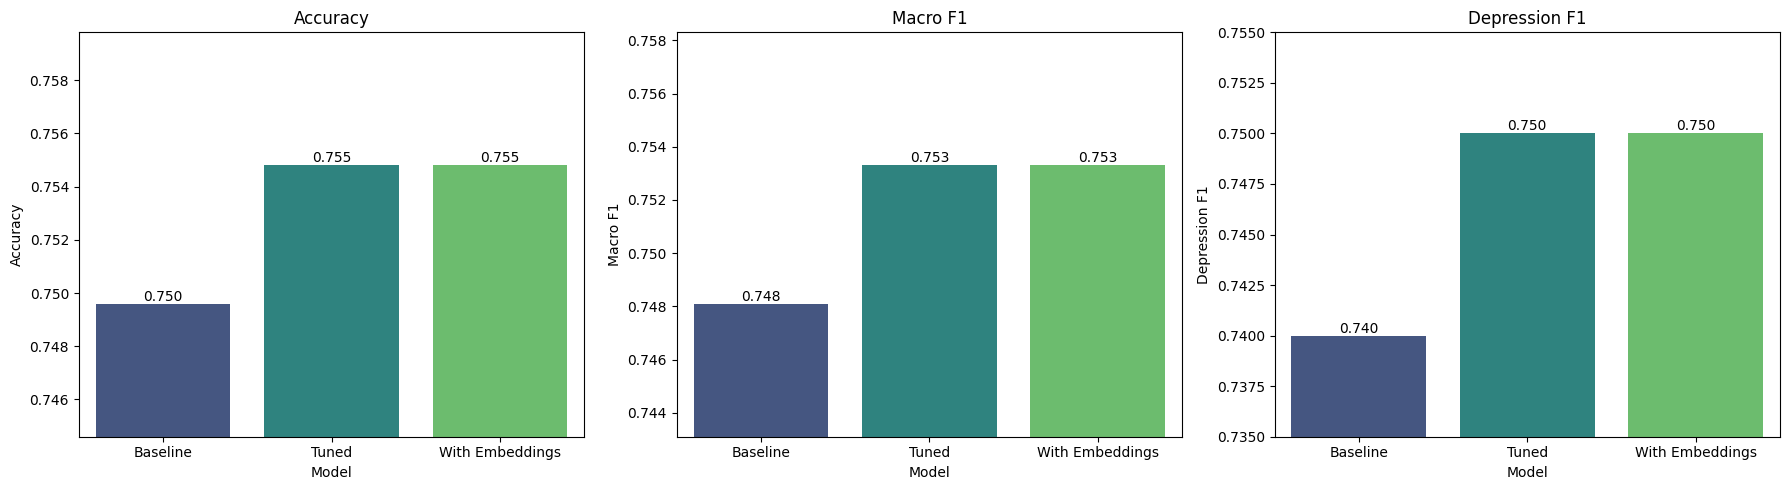

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data
data = {
    'Model': ['Baseline', 'Tuned', 'With Embeddings'],
    'Accuracy': [0.7496, 0.7548, 0.7548],
    'Macro F1': [0.7481, 0.7533, 0.7533],
    'Depression F1': [0.74, 0.75, 0.75],
    'MentalHealth F1': [0.67, 0.67, 0.67]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'Macro F1', 'Depression F1']

for ax, metric in zip(axes, metrics):
    sns.barplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')
    ax.set_title(metric)

    # Zoom in on the Y-axis to highlight differences
    min_val = df[metric].min() - 0.005
    max_val = df[metric].max() + 0.005
    ax.set_ylim(min_val, max_val)

    # Add value labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
